# Assignment 5

This is an basecode for assignment 5 of Artificial Intelligence class (CSCE-4613), Fall 2020

In [ ]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms

from PIL import Image
import pickle
import matplotlib.pyplot as plt

## Question 1
### Define Input Transformation

In [ ]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 224
image_transforms = transforms.Compose([
                           transforms.Resize(IMAGE_SIZE),
                           transforms.CenterCrop(IMAGE_SIZE),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = MEAN, std = STD)])

index2name = pickle.load(open("imagenet_class_names.pkl", "rb"))


### Define Model

In [ ]:
model = torchvision.models.densenet121(pretrained=True)
softmax_layer = nn.Softmax(dim=1)
model.eval()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Classify and Visualize Image

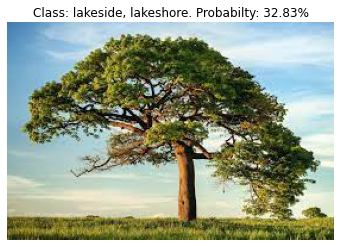

In [ ]:
image_path = "tree.jpg"
original_image = Image.open(image_path).convert("RGB")
image = image_transforms(original_image)
image = image.unsqueeze(0)
output = softmax_layer(model(image))

prediction = torch.argmax(output, dim=1).item()
prob = output[0, prediction].item() * 100
predicted_name = index2name[prediction]

plt.imshow(original_image)
plt.title("Class: %s. Probabilty: %.2f" % (predicted_name, prob) + "%")
plt.axis("off")
plt.show()

### Get Top-K Predictions

In [ ]:
K = 5
indices = torch.argsort(output, dim = 1, descending=True)
for i in range(0, K):
  prob = output[0, indices[0, i].item()].item() * 100
  predicted_name = index2name[indices[0, i].item()]
  print("%d-th. Class: %s. Probabilty: %0.2f" % (i + 1, predicted_name, prob) + "%")

1-th. Class: lakeside, lakeshore. Probabilty: 32.83%
2-th. Class: megalith, megalithic structure. Probabilty: 8.00%
3-th. Class: seashore, coast, seacoast, sea-coast. Probabilty: 7.75%
4-th. Class: beacon, lighthouse, beacon light, pharos. Probabilty: 5.43%
5-th. Class: valley, vale. Probabilty: 3.21%


## Question 2

### Define Training Data Loader

In [ ]:
train_batch_size = 64
train_dataset = torchvision.datasets.CIFAR10(root = "data/CIFAR-10",
                                             train = True,
                                             transform = transforms.ToTensor(),
                                             download = True)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = train_batch_size,
                                           shuffle = True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/CIFAR-10/cifar-10-python.tar.gz to data/CIFAR-10


### Define Model and Training Framework

In [9]:
cuda = torch.cuda.is_available()
model = torchvision.models.resnet18(pretrained=False, num_classes = 10)
if cuda:
  model.cuda()

model.train()
learning_rate = 0.001
num_epochs = 5
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()
loss_logger = []
accuracy_logger = []

for epoch in range(1, num_epochs + 1):
  for it, (images, labels) in enumerate(train_loader):
      if cuda:
        images = images.cuda()
        labels = labels.cuda()

      outputs = model(images)
      predictions = torch.argmax(outputs, dim=1)
      accuracy = (predictions == labels).float().mean() * 100
      loss = loss_fn(outputs, labels)
      
      optim.zero_grad()
      loss.backward()
      optim.step()

      loss = loss.item()
      accuracy = accuracy.item()
      
      loss_logger.append(loss)
      accuracy_logger.append(accuracy)

      if it % 200 == 0:
        print("Epoch [%d/%d]. Iter [%d/%d]. Loss: %0.4f. Accuracy: %.2f" % (epoch, num_epochs, it + 1, len(train_loader), loss, accuracy))

torch.save(model.state_dict(), "CIFAR10-ResNet18.pth")

plt.figure()
plt.plot(loss_logger)
plt.title("Training Losses")
plt.show()

plt.figure()
plt.plot(accuracy_logger)
plt.title("Training Accuracies")
plt.show()

Epoch [1/5]. Iter [1/782]. Loss: 2.5092. Accuracy: 10.94
Epoch [1/5]. Iter [201/782]. Loss: 1.3791. Accuracy: 51.56
Epoch [1/5]. Iter [401/782]. Loss: 1.4964. Accuracy: 54.69


KeyboardInterrupt: ignored

### Load Model and Evaluate Model On Testing Dataset

In [ ]:
cuda = torch.cuda.is_available()
model = torchvision.models.resnet18(pretrained=False, num_classes = 10)
if cuda:
  model.cuda()

model.load_state_dict(torch.load("CIFAR10-ResNet18.pth"))
model.eval()

test_dataset = torchvision.datasets.CIFAR10(root = "data/CIFAR-10",
                                             train = False,
                                             transform = transforms.ToTensor(),
                                             download = True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size = 1,
                                           shuffle = True)

final_accuracy = 0.0
for it, (images, labels) in enumerate(test_loader):
  if cuda:
    images = images.cuda()
    labels = labels.cuda()

  outputs = model(images)
  predictions = torch.argmax(outputs, dim=1)
  accuracy = (predictions == labels).float().mean() * 100
  
  accuracy = accuracy.item()
  final_accuracy += accuracy

  if accuracy == 100:
    corrects.append(images.cpu().numpy()[0].transpose(1,2,0))

  y_pred.append(predictions[0].item())
  y_true.append(labels[0].item())

  indices = torch.argsort(outputs, dim = -1, descending = True)
  if labels[0].item() in indices[:5]:
    top_5_accuracy += 100.0

  if it % 500 == 0:
    print("Iter [%d/%d]. Accuracy: %.2f" % (it + 1, len(test_loader), accuracy))

print("Final Accuracy: %0.2f" % (final_accuracy / len(test_loader)))

NameError: ignored